<div style="background-color: powderblue; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;">🏁 Setting the stage 🎌</h1>
</div>

In [1]:
!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install "/kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl"

Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=e310e4f2ac655ed803b6e542006b63976d119bd675730556e47c8eef54e0aab6
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect
Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


In [2]:
import numpy as np 
import pandas as pd
import string
from collections import Counter
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from autocorrect import Speller
from spellchecker import SpellChecker

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

In [3]:
#Train
prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
df = prompts.merge(summaries, on = ['prompt_id'],how ='left')

#Test
prompts_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
summaries_test = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
test = prompts_test.merge(summaries_test, on = ['prompt_id'],how ='left')

<div style="background-color: #c4affa; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🧹 Data Cleaning & Processing ⚙️</h1>
</div>

In [4]:
spell = Speller(lang='en')

df['correct_text'] = df['text'].apply(lambda x: "".join([spell(i) for i in x]))
test['correct_text'] = test['text'].apply(lambda x: "".join([spell(i) for i in x]))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text


df['correct_text'] = df['text'].apply(lambda x: "".join([spell(i) for i in x]))
test['correct_text'] = test['text'].apply(lambda x: "".join([spell(i) for i in x]))

df['prompt_text'] = df['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))
test['prompt_text'] = test['prompt_text'].apply(lambda x: "".join([spell(i) for i in x]))

<div style="background-color: #ea9bc4; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;">  🧑‍🔬 Feature Engineering 👨‍🔬</h1>
</div>

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 1</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Ratio of No of words in Student's response vs context</h1></div>

In [5]:
def wordsRatio(context, response):
    context = context.split()
    response = response.split()
    return len(response)/len(context)

df["word_count_ratio"] = df.apply(lambda x: wordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["word_count_ratio"] = test.apply(lambda x: wordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 2</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Number of spelling errors in Student's summary</h1></div>

In [6]:
def misspelledRatio(x):
    spell = SpellChecker()
    words = x.split()
    misspelled = spell.unknown(words)
    return len(misspelled)/len(words)

df["misspelled_ratio"] = df['text'].apply(lambda x: misspelledRatio(x))  
test["misspelled_ratio"] = test['text'].apply(lambda x: misspelledRatio(x))

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 3</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Stop word Ratio in Student's summary</h1></div>

In [7]:
stop_words = stopwords.words('english')
def StopwordsRatio(context, response):
    length  = len(response.split())
    response = " ".join([i for i in response.split() if i in stop_words]) 
    return len(response)/length

df["stop_word_ratio"] = df.apply(lambda x: StopwordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["stop_word_ratio"] = test.apply(lambda x: StopwordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 4</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Count of same words in Student's summary</h1></div>

In [8]:
def sameWordsRatio(context, response):
    context = " ".join([i for i in context.split() if i not in stop_words]) 
    response = " ".join([i for i in response.split() if i not in stop_words]) 
    return len(set(response).intersection(set(context)))/len(response)

df["same_word_ratio"] = df.apply(lambda x: sameWordsRatio(x['prompt_text'], x['correct_text']), axis=1)
test["same_word_ratio"] = test.apply(lambda x: sameWordsRatio(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 5</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Average reading speed in words per minute </h1></div>

In [9]:
def readTime(x):
    average_wpm = 200
    word_count = len(x.split())
    return word_count / average_wpm

df["read_time"] = df['text'].apply(lambda x: readTime(x))  
test["read_time"] = test['text'].apply(lambda x: readTime(x))  

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 6</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Diversity of words in the Student's response </h1></div>

In [10]:
def diversityIndex(x):
    words = x.split()
    word_counts = Counter(words)
    total_words = len(words)
    return 1 - sum((count / total_words) ** 2 for count in word_counts.values())

df["diversity_index"] = df['text'].apply(lambda x: diversityIndex(x))  
test["diversity_index"] = test['text'].apply(lambda x: diversityIndex(x))  

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 7</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> TF IDF to identify most frequent words in context and response </h1></div>

In [11]:
def tfidfImportance(context, response):
    top_n = 10

    context = " ".join([i for i in context.split() if i not in stop_words]) 
    response = " ".join([i for i in response.split() if i not in stop_words]) 
    
    corpus = [
        context, response
     ]

    tfidf_unigram = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_unigram_matrix = tfidf_unigram.fit_transform(corpus)
    unigram_feature_names = tfidf_unigram.get_feature_names_out()
    dense_unigram_array = tfidf_unigram_matrix.toarray()
    unigram_df = pd.DataFrame(data=dense_unigram_array, columns=unigram_feature_names)

    top_unigrams = []
    for index, row in unigram_df.iterrows():
        top_unigrams.append(list(row.nlargest(top_n).index))

    tfidf_bigram = TfidfVectorizer(ngram_range=(2, 2)) 

    tfidf_bigram_matrix = tfidf_bigram.fit_transform(corpus)
    bigram_feature_names = tfidf_bigram.get_feature_names_out()
    dense_bigram_array = tfidf_bigram_matrix.toarray()
    bigram_df = pd.DataFrame(data=dense_bigram_array, columns=bigram_feature_names)

    top_bigrams = []
    for index, row in bigram_df.iterrows():
        top_bigrams.append(list(row.nlargest(top_n).index))


    return len(set(top_unigrams[0]).intersection(set(top_unigrams[1])))/top_n, len(set(top_bigrams[0]).intersection(set(top_bigrams[1])))/top_n

df[['top_unigrams_ratio','top_bigrams_ratio']]= df.apply(lambda x: tfidfImportance(x['prompt_text'], x['correct_text']), axis=1, result_type ='expand')
test[['top_unigrams_ratio','top_bigrams_ratio']]= test.apply(lambda x: tfidfImportance(x['prompt_text'], x['correct_text']), axis=1, result_type ='expand')

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 8</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Cosine similarity of context and response using TD IDF vectors</h1></div>

In [12]:
def tdidfSimilarity(context, response):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform([context, response])
    return cosine_similarity(vectors[0:1], vectors[1:2])[0][0] 

df['tfidf_similarity']= df.apply(lambda x: tdidfSimilarity(x['prompt_text'], x['correct_text']), axis=1)
test['tfidf_similarity']= test.apply(lambda x: tdidfSimilarity(x['prompt_text'], x['correct_text']), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 9</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> N Grams Co occurence context and response </h1></div>

In [13]:
def tokenize(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence.lower())
    tokens = sentence.split()
    return tokens

def generate_ngrams(tokens, n):
    ngrams = []
    for i in range(len(tokens) - n + 1):
        ngram = tuple(tokens[i:i + n])
        ngrams.append(ngram)
    return ngrams


def cooccurrenceRatio(context, response, n_gram_size = 2):
    tokens1 = tokenize(context)
    tokens2 = tokenize(response)

    ngrams1 = generate_ngrams(tokens1, n_gram_size)
    ngrams2 = generate_ngrams(tokens2, n_gram_size)

    co_occurrence_count = len(set(ngrams1) & set(ngrams2))
    
    return co_occurrence_count/(min(len(ngrams1),len(ngrams2))+1)

df['bi_gram_ratio'] = df.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)
test['bi_gram_ratio'] = test.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)

df['tri_gram_ratio'] = df.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text'], n_gram_size = 3), axis=1)
test['tri_gram_ratio'] = test.apply(lambda x: cooccurrenceRatio(x['prompt_text'], x['correct_text'],n_gram_size = 3 ), axis=1)

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 10</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Check punctuation in Student's response </h1></div>

In [14]:
def checkPunctuations(x):
    punctuation_count = 0

    for char in x:
        if char in string.punctuation:
            punctuation_count += 1
    return punctuation_count/len(x.split())

df["punctuation_ratio"] = df['text'].apply(lambda x: checkPunctuations(x))
test["punctuation_ratio"] = test['text'].apply(lambda x: checkPunctuations(x)) 

<div><h1 style="text-align: left; font-size: 25px;"> 📍 Feature 11</h1></div>
<div><h1 style="text-align: left; font-size: 20px;"> Identifying Co occurences of NER in context and response </h1></div>

In [15]:
nlp = spacy.load("en_core_web_sm")

def nerCooccurrenceRatio(context, response, n_gram_size = 2):
    
    doc1 = nlp(context)
    doc2 = nlp(response)
    
    entities1 = {ent.text for ent in doc1.ents}
    entities2 = {ent.text for ent in doc2.ents}
    
    overlap_entities = entities1.intersection(entities2)
    return len(overlap_entities)/(min(len(entities1),len(entities2))+1)


df['nercooccurrence_ratio'] = df.apply(lambda x: nerCooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)
test['nercooccurrence_ratio'] = test.apply(lambda x: nerCooccurrenceRatio(x['prompt_text'], x['correct_text']), axis=1)

<div style="background-color: #b6d7a8; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🔬 EDA ⚗️</h1>
</div>

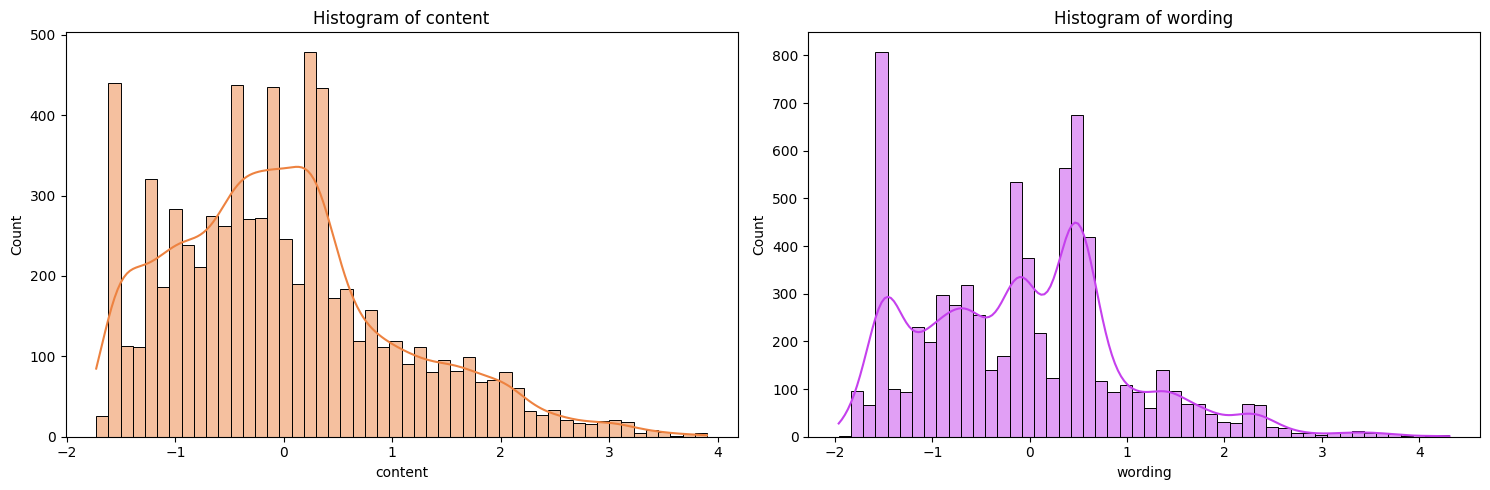

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2, 1)  
sns.histplot(x=df['content'], bins=50, kde=True, color='#ed8240')
plt.title(f"Histogram of content")

plt.subplot(1,2, 2)  
sns.histplot(x=df['wording'], bins=50, kde=True, color='#c540ed')
plt.title(f"Histogram of wording")

plt.tight_layout() 
plt.show()

In [17]:
cols = [
    'word_count_ratio', 
    'misspelled_ratio', 
    'stop_word_ratio',
    'same_word_ratio', 
    'read_time', 
    'diversity_index', 
    'top_unigrams_ratio',
    'top_bigrams_ratio',
    'tfidf_similarity',
    'punctuation_ratio', 
    'bi_gram_ratio',
    'tri_gram_ratio', 
    'nercooccurrence_ratio'
]

<Axes: >

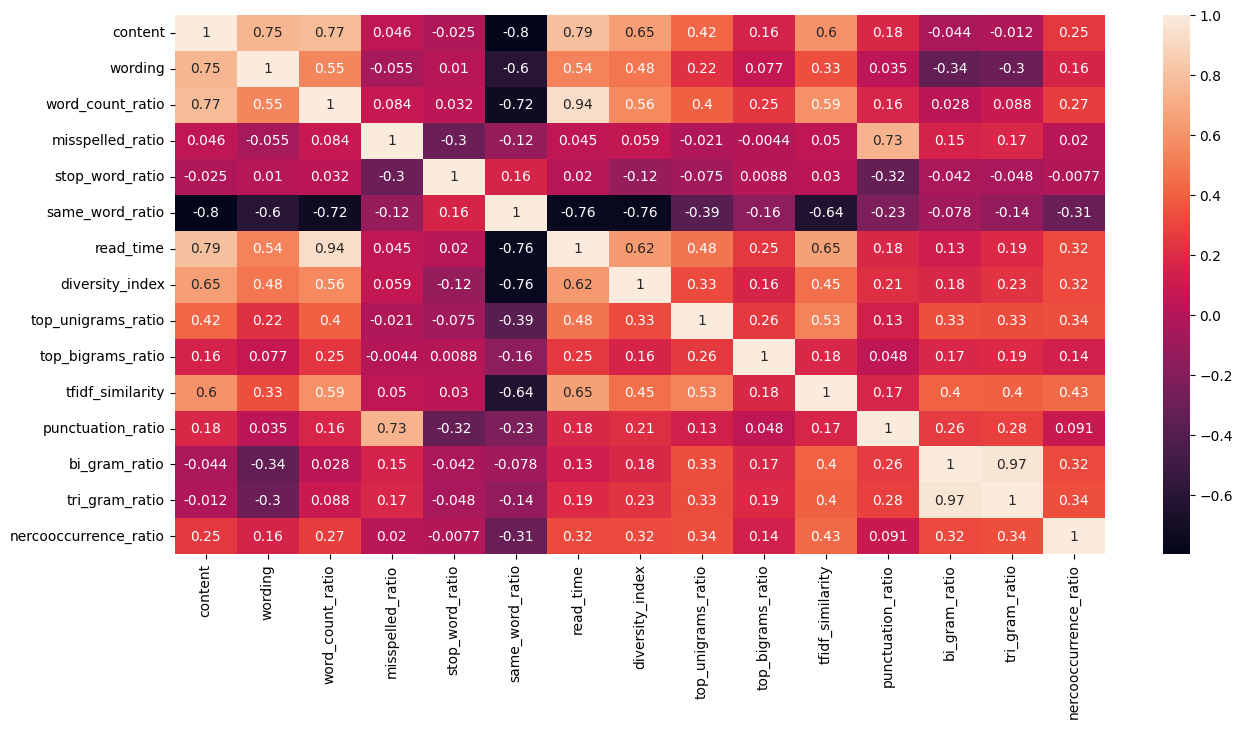

In [18]:
all_cols = ['content','wording'] + cols
plt.figure(figsize=(15, 7))
sns.heatmap(df[all_cols].corr(), annot=True)

Plots for word_count_ratio


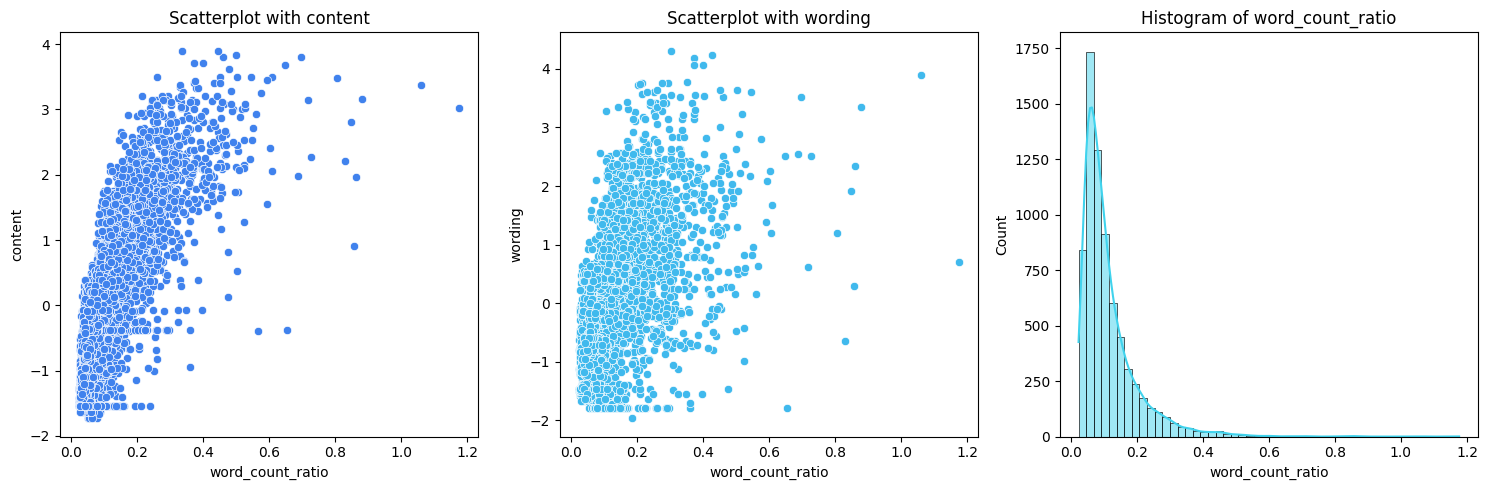

Plots for misspelled_ratio


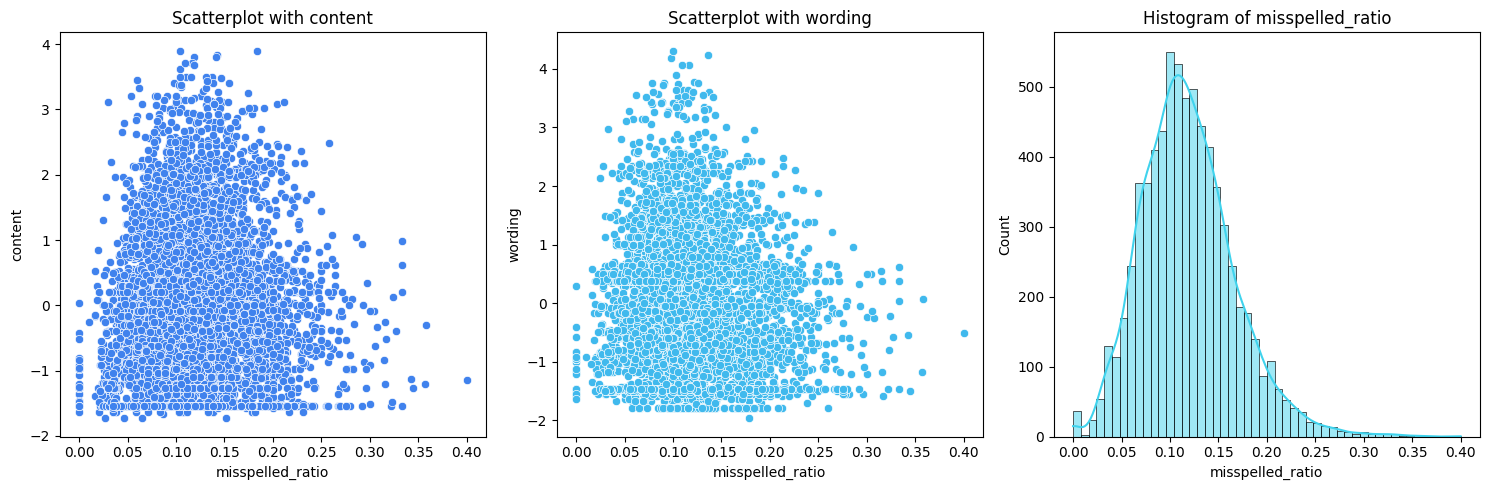

Plots for stop_word_ratio


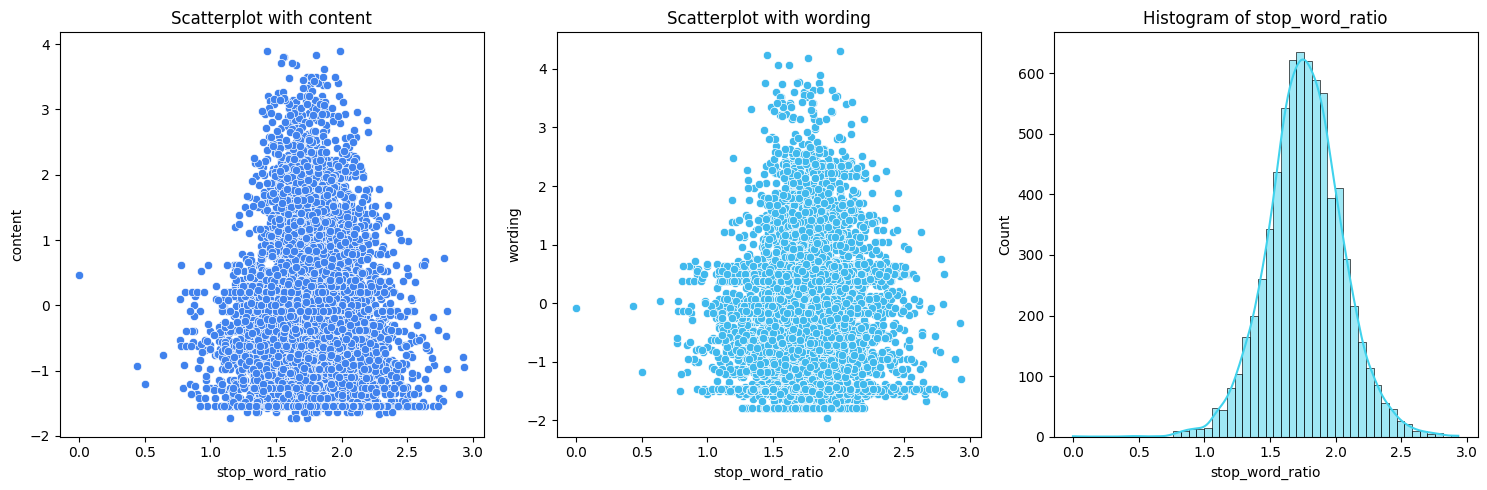

Plots for same_word_ratio


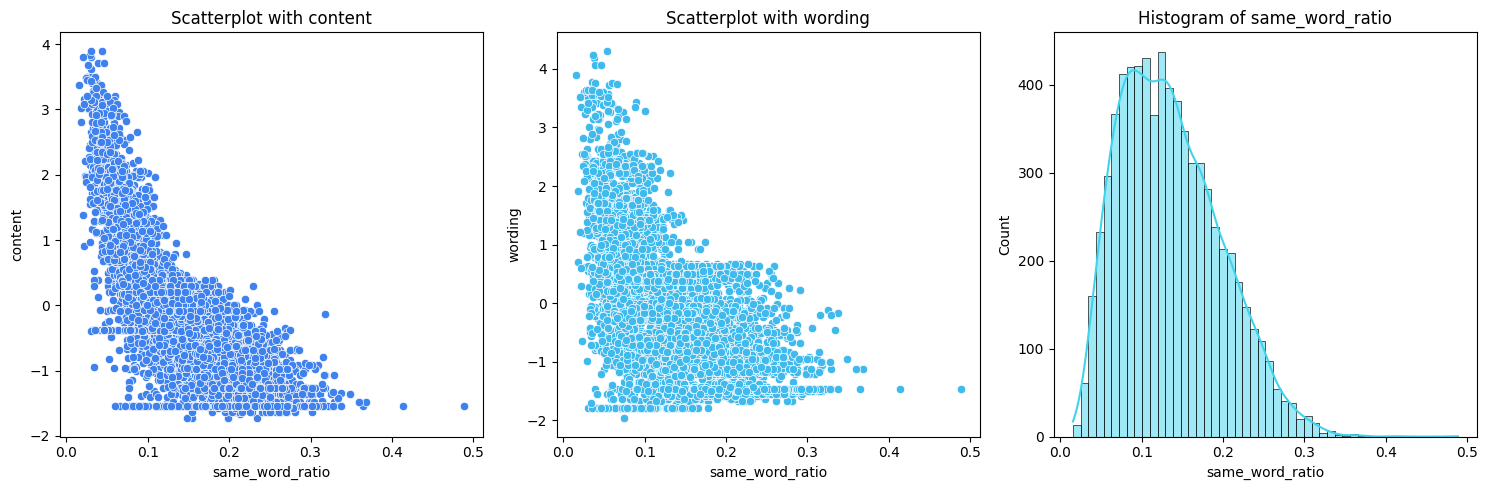

Plots for read_time


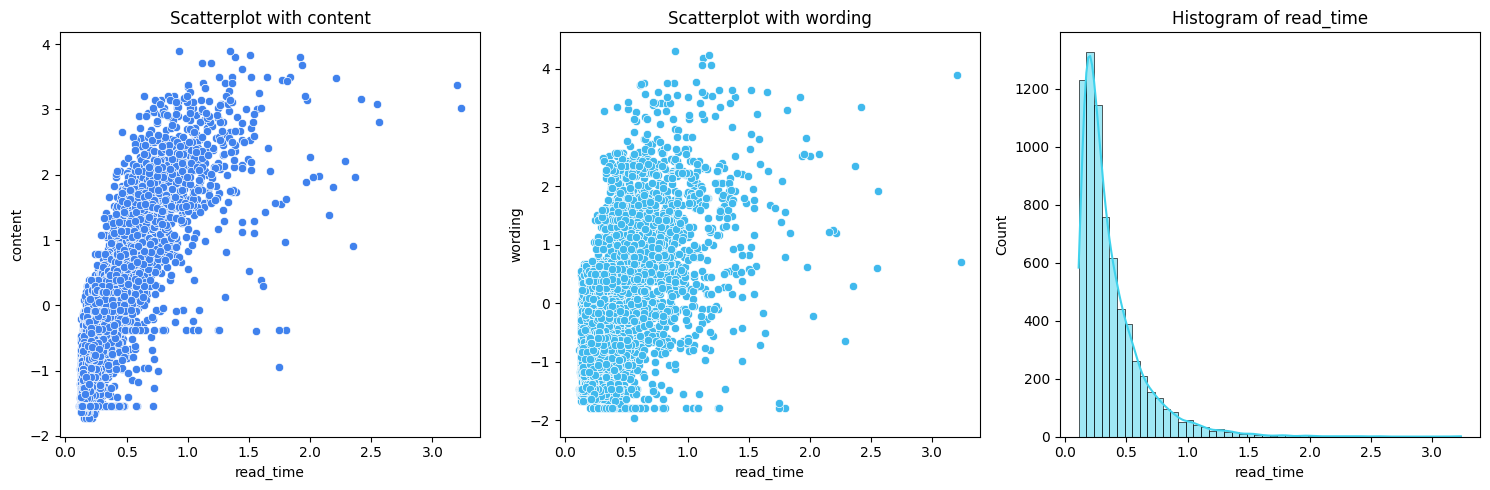

Plots for diversity_index


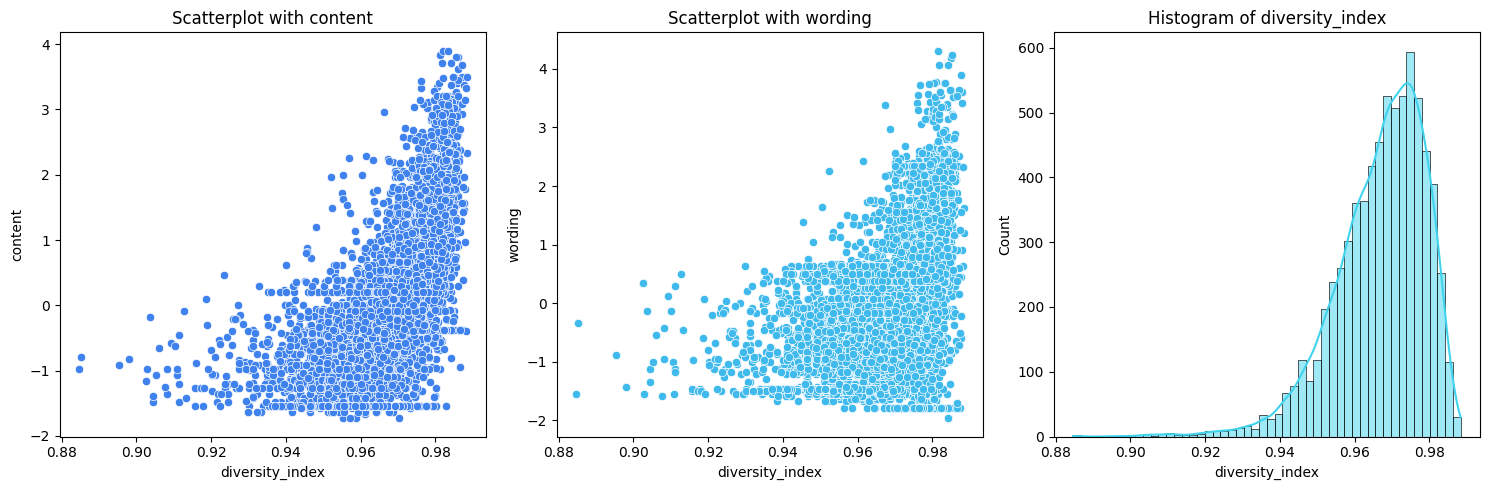

Plots for top_unigrams_ratio


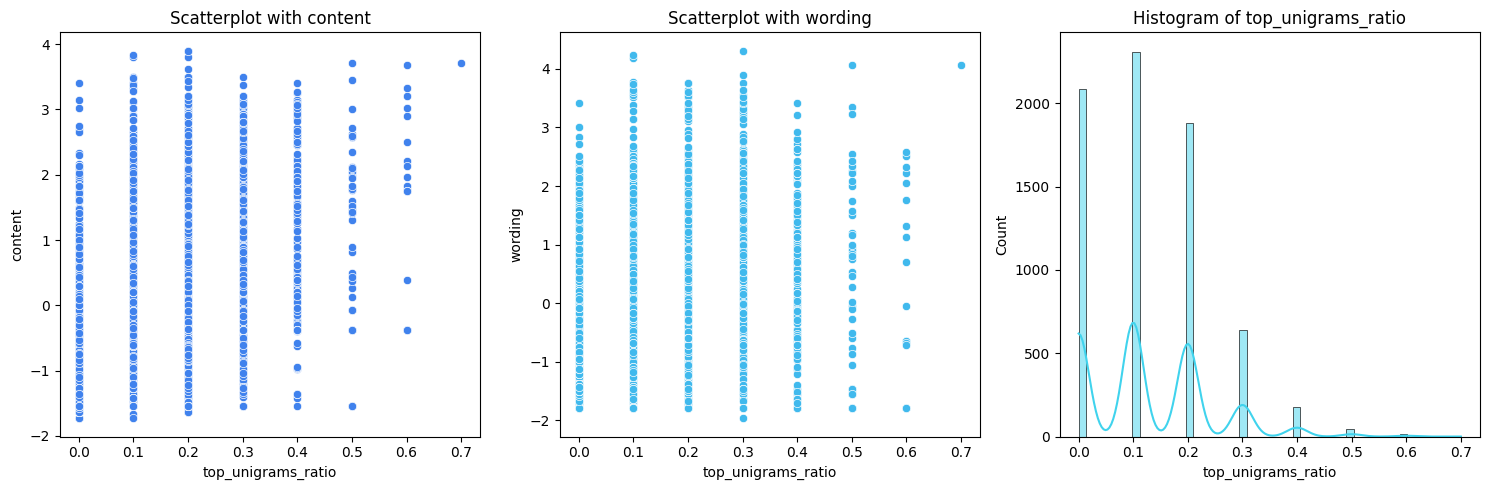

Plots for top_bigrams_ratio


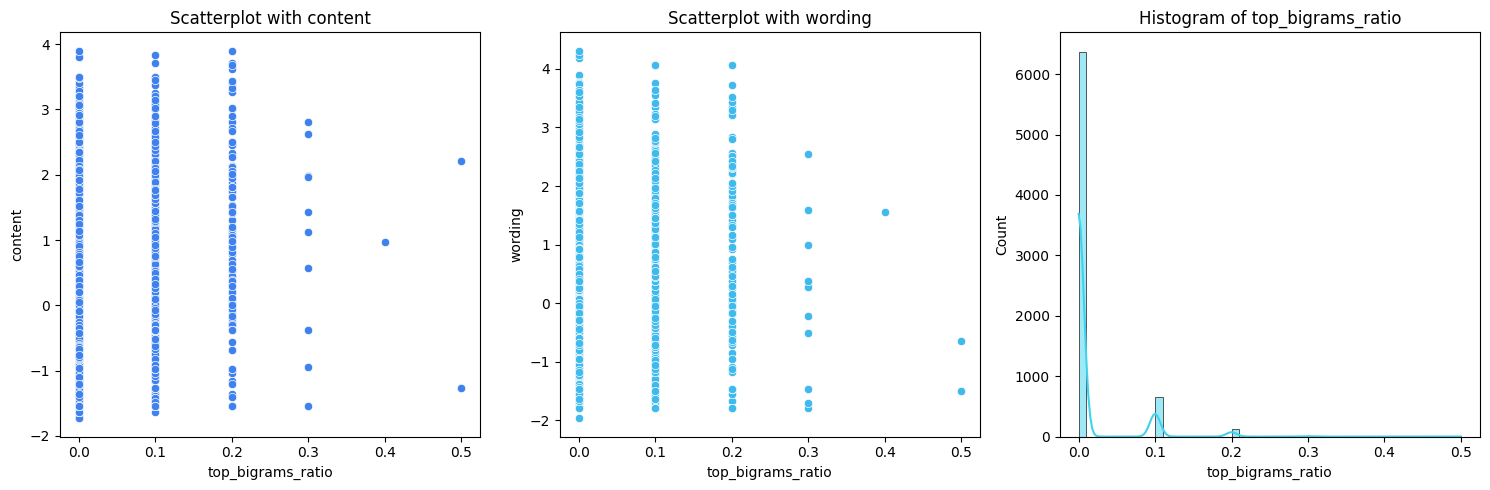

Plots for tfidf_similarity


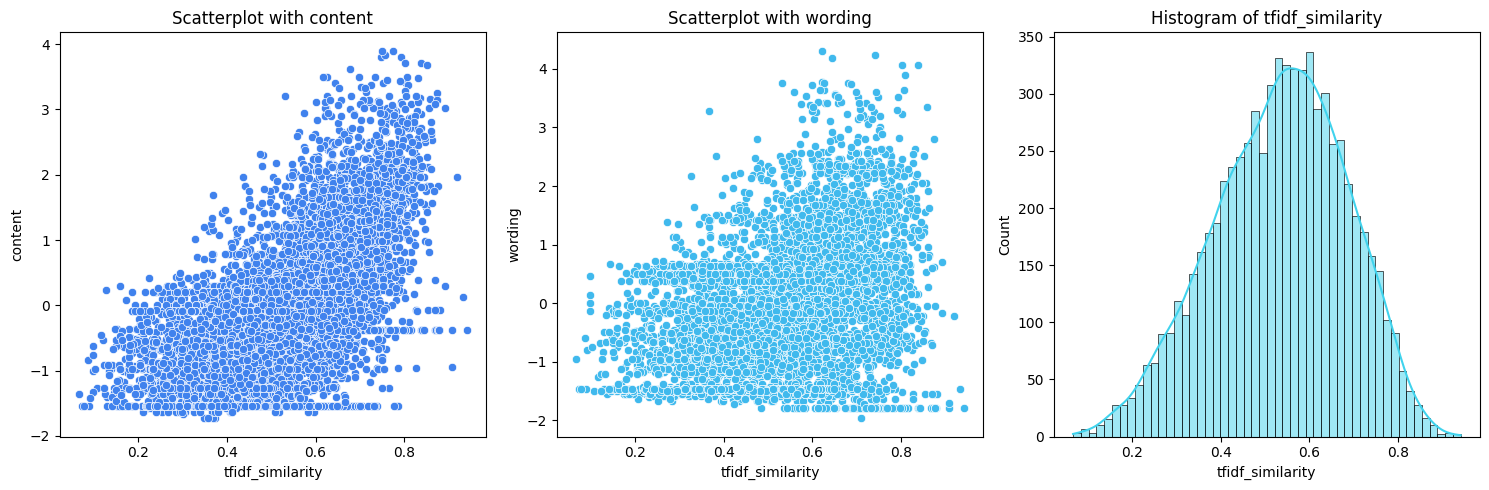

Plots for punctuation_ratio


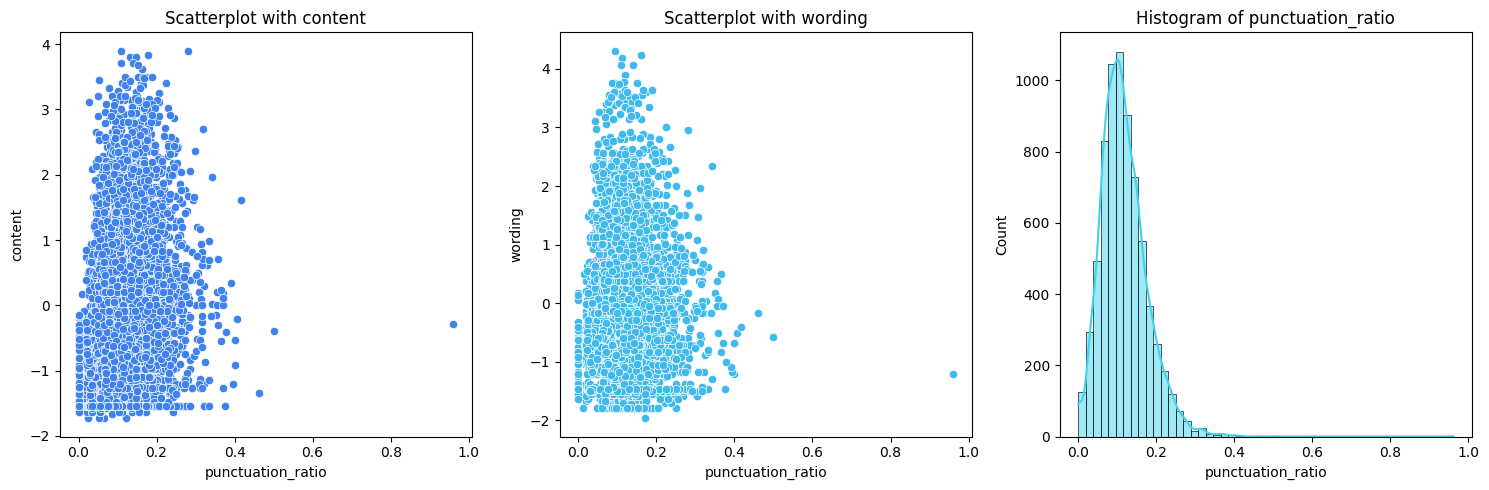

Plots for bi_gram_ratio


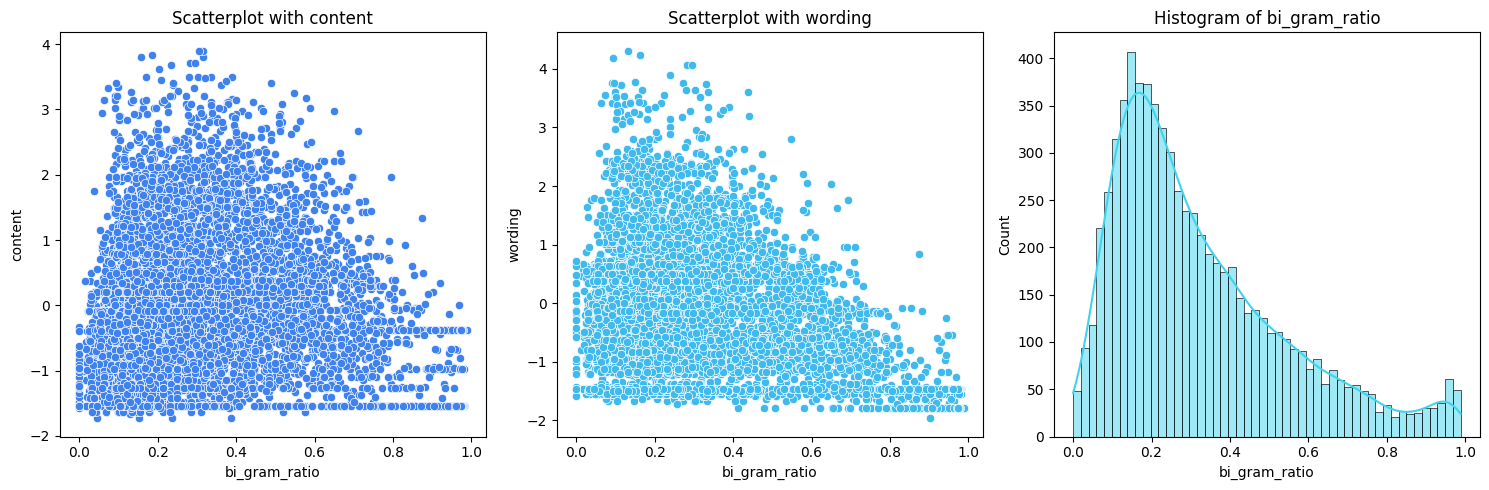

Plots for tri_gram_ratio


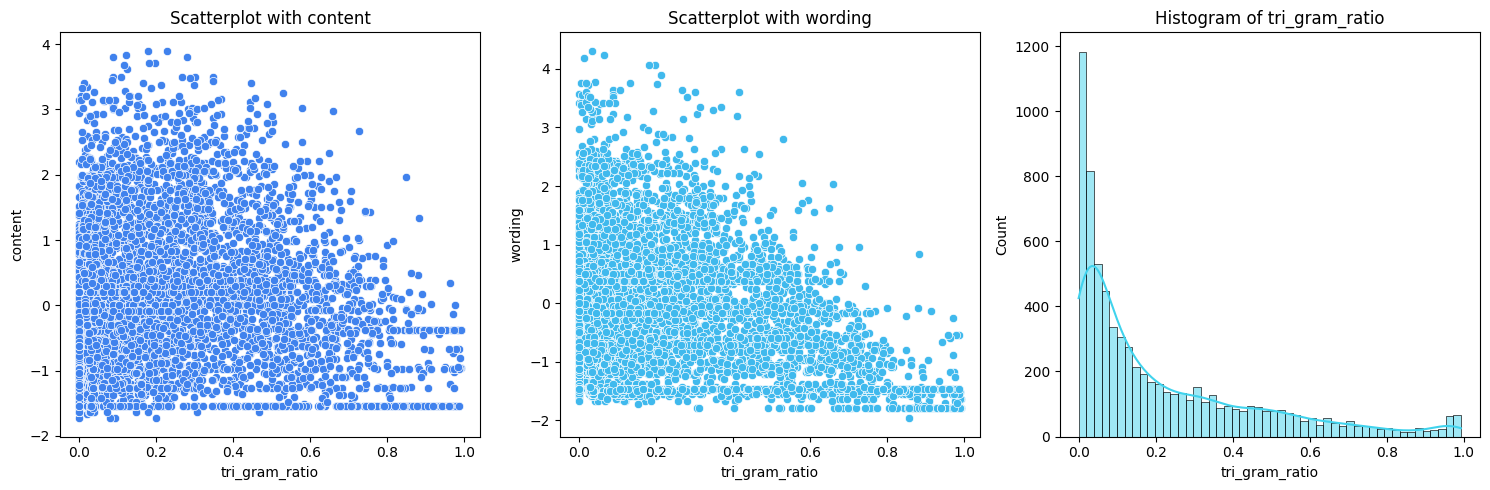

Plots for nercooccurrence_ratio


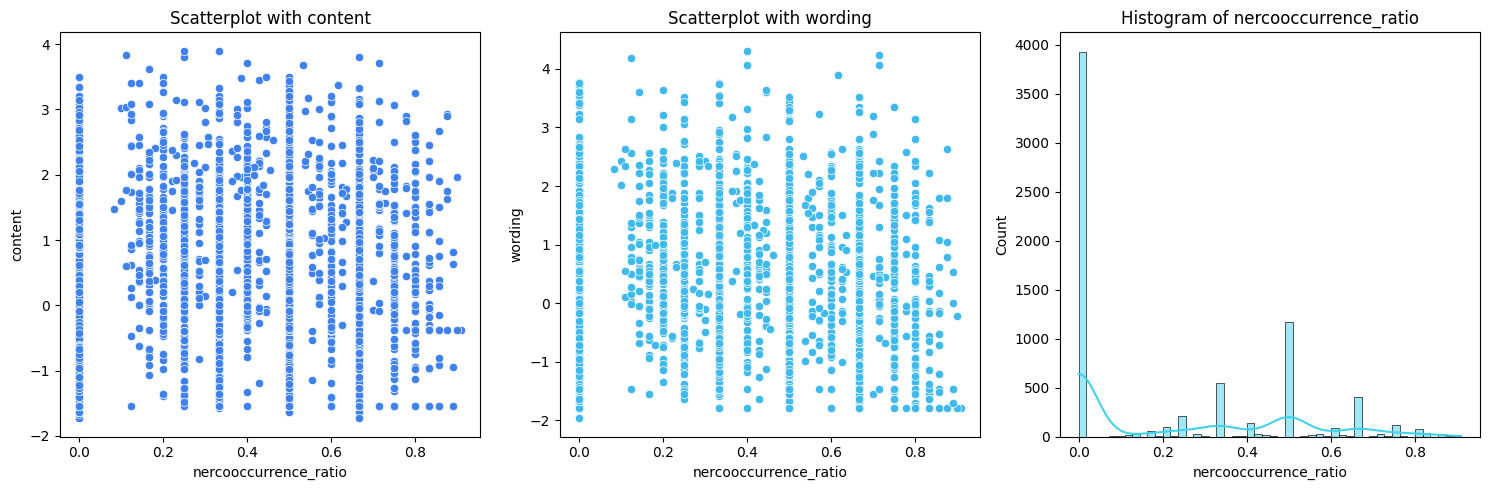

In [19]:
for col in cols:
    print(f'Plots for {col}')
    plt.figure(figsize=(15, 5))

    plt.subplot(1,3, 1)  
    sns.scatterplot(x=df[col], y=df['content'], color='#4082ed')
    plt.title("Scatterplot with content")

    plt.subplot(1, 3, 2)  
    sns.scatterplot(x=df[col], y=df['wording'], color='#40b9ed')
    plt.title("Scatterplot with wording")

    plt.subplot(1, 3, 3)  
    sns.histplot(x=df[col], bins=50, kde=True, color='#40d3ed')
    plt.title(f"Histogram of {col}")

    plt.tight_layout() 
    plt.show()


<div style="background-color: #8dc1e9; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🐥 Bert Embedding 🐥</h1>
</div>

In [20]:
model_name = "/kaggle/input/huggingface-bert/bert-large-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


def get_embeddings(document):
    max_chunk_length = 1024
    
    chunks = [document[i:i + max_chunk_length] for i in range(0, len(document), max_chunk_length)]

    chunk_embeddings = []

    for chunk in chunks:
        input_ids = tokenizer.encode(chunk, add_special_tokens=True, truncation=True, max_length=1024, return_tensors="pt")

        with torch.no_grad():
            outputs = model(input_ids)
            cls_embedding = outputs.last_hidden_state[:, 0, :]

        chunk_embeddings.append(cls_embedding)

        final_embedding = torch.mean(torch.stack(chunk_embeddings), dim=0)
        
        return final_embedding

In [21]:
# Embedding of prompt_text
df["text_emb"] = df['prompt_text'].apply(lambda x: get_embeddings(x))  
df["flattened_embedding"] = df["text_emb"].apply(lambda x: x.flatten().numpy())
emb_df = pd.DataFrame(df["flattened_embedding"].to_list())

test["text_emb"] = test['prompt_text'].apply(lambda x: get_embeddings(x))  
test["flattened_embedding"] = test["text_emb"].apply(lambda x: x.flatten().numpy())
emb_test = pd.DataFrame(test["flattened_embedding"].to_list())

In [22]:
# Embedding of text
df["correct_text_emb"] = df['correct_text'].apply(lambda x: get_embeddings(x))  
df["correct_text_flattened_embedding"] = df["correct_text_emb"].apply(lambda x: x.flatten().numpy())
emb_corrt_df = pd.DataFrame(df["correct_text_flattened_embedding"].to_list())

test["correct_text_emb"] = test['correct_text'].apply(lambda x: get_embeddings(x))  
test["correct_text_flattened_embedding"] = test["correct_text_emb"].apply(lambda x: x.flatten().numpy())
emb_corrt_test = pd.DataFrame(test["correct_text_flattened_embedding"].to_list())

In [23]:
train = df[cols ]
test_score = test[cols]
Y = df[['content','wording']]

In [24]:
X_train, X_val = train_test_split(train, test_size=0.1)

In [25]:
emb_corrt_train = emb_corrt_df.filter(X_train.index, axis=0)
emb_corrt_val = emb_corrt_df.filter(X_val.index, axis=0)

emb_train = emb_df.filter(X_train.index, axis=0)
emb_val = emb_df.filter(X_val.index, axis=0)

Y_train = Y.filter(X_train.index, axis=0)
Y_val = Y.filter(X_val.index, axis=0)

In [26]:
num_side_features = len(X_train.columns)
hidden_dim1 = int(num_side_features/2)
num_emb = 1024

In [27]:
batch_size = 32

context_inputs_train = torch.from_numpy(emb_train.to_numpy())
response_inputs_train = torch.from_numpy(emb_corrt_train.to_numpy())
side_feat_train = torch.from_numpy(X_train.to_numpy().astype(np.float32))
Y_train = torch.from_numpy(Y_train.to_numpy())

context_inputs_val = torch.from_numpy(emb_val.to_numpy())
response_inputs_val = torch.from_numpy(emb_corrt_val.to_numpy())
side_feat_val = torch.from_numpy(X_val.to_numpy().astype(np.float32))
Y_val = torch.from_numpy(Y_val.to_numpy())

context_inputs_test = torch.from_numpy(emb_test.to_numpy())
response_inputs_test = torch.from_numpy(emb_corrt_test.to_numpy())
side_feat_test = torch.from_numpy(test_score.to_numpy().astype(np.float32))

dataset_tensor_train = TensorDataset(context_inputs_train, response_inputs_train, side_feat_train, Y_train)
dataset_tensor_val = TensorDataset(context_inputs_val, response_inputs_val, side_feat_val, Y_val)

train_loader = DataLoader(dataset_tensor_train, batch_size, shuffle=False)  
val_loader = DataLoader(dataset_tensor_val, batch_size)

<div style="background-color: #ffe599; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> 🏭 Deep learning Architecture 🏗️</h1>
</div>

In [28]:
# Define the deep learning model
class BertDotProductModel(nn.Module):
    def __init__(self, num_emb, num_side_features, hidden_dim1):
        super(BertDotProductModel, self).__init__()

        self.side_feature_layer = nn.Linear(num_side_features, hidden_dim1)  
        
        self.fc1 = nn.Linear((1024 + hidden_dim1 + 1), 512)
        self.fc2 = nn.Linear(512, 512) 
        self.fc3 = nn.Linear(512, 512) 
        self.fc4 = nn.Linear(512, 256) 
        self.fc5 = nn.Linear(256, 128) 
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 2) 
        self.relu = torch.nn.ReLU()

    def forward(self, context, response, side_features):

        dot_product = torch.sum(context * response, dim=1)
        side_features = self.side_feature_layer(side_features)
        residual = torch.sub(context, response)
        concat_features = torch.cat((dot_product.unsqueeze(1), residual, side_features), dim=1)

        fc_output = self.relu(concat_features)
        fc_output = self.fc1(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc3(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc4(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc5(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc6(fc_output)
        fc_output = self.relu(fc_output)
        fc_output = self.fc7(fc_output)
        
        return fc_output

In [29]:
model = BertDotProductModel(num_emb, num_side_features, hidden_dim1)

In [30]:
training_loss = []
validation_loss = []

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for context, response, side_features, target in train_loader:
        optimizer.zero_grad()
        outputs = model(context, response, side_features)  
    
        target = target.to(torch.float)

        loss1 = torch.sqrt(criterion(outputs[:, 0].squeeze(), target[:,0]))
        loss2 = torch.sqrt(criterion(outputs[:, 1].squeeze(), target[:,1])) 
        
        loss = loss1 + loss2
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    training_loss.append(total_loss / len(train_loader))

    model.eval()
    valid_loss = 0.0

    with torch.no_grad():
        for context, response, side_features, target in val_loader:
            outputs = model(context, response, side_features)
            loss1 = torch.sqrt(criterion(outputs[:, 0].squeeze(), target[:,0])) 
            loss2 = torch.sqrt(criterion(outputs[:, 1].squeeze(), target[:,1])) 
            
            loss = loss1 + loss2 
            
            valid_loss += loss.item()
            
    validation_loss.append(valid_loss / len(val_loader))

    scheduler.step()

<Axes: >

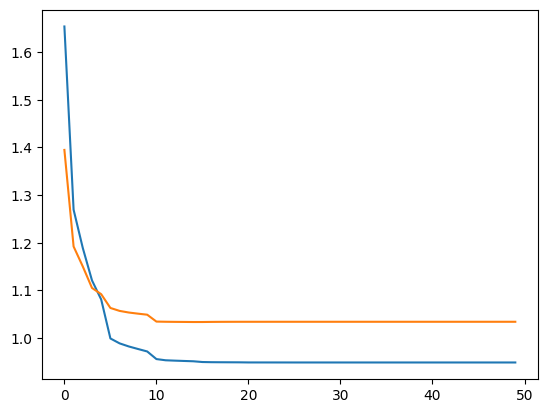

In [31]:
sns.lineplot(x=[i for i in range(num_epochs)], y=training_loss)
sns.lineplot(x=[i for i in range(num_epochs)], y=validation_loss)

In [32]:
model.eval()

with torch.no_grad():
    outputs = model(context_inputs_test, response_inputs_test, side_feat_test)

outputs = outputs.numpy()

In [33]:

content_list = outputs[:, 0].tolist()
wording_list = outputs[:, 1].tolist()

submission = test[['student_id']]
submission['content'] = content_list
submission['wording'] = wording_list

submission.to_csv('submission.csv', index=False)

submission.head()

/tmp/ipykernel_20/4229765598.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['content'] = content_list
/tmp/ipykernel_20/4229765598.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['wording'] = wording_list


,student_id,content,wording
0,000000ffffff,0.665145,0.279959
1,222222cccccc,0.109918,-0.246998
2,111111eeeeee,0.372517,-0.019198
3,333333dddddd,0.598580,-0.049628


<div style="background-color: #bcbcbc; padding: 10px; border-radius: 15px;">
    <h1 style="text-align: center; font-size: 28px;"> If you find it useful, please upvote for my efforts ⬆️ </h1>
</div>